In [89]:
DATASET_DIR = "../datasets"
OUTPUT_DIR = "../outputs"

# name of the dataset to preprocess
DATASET_NAME, SPLIT_NAME = "narrativeqa", "dev"

IS_LOCAL_FS_DATASET = True 

if isinstance(DATASET_NAME, tuple):
    NORMALIZED_DATASET_NAME = "".join(DATASET_NAME)
else:
    NORMALIZED_DATASET_NAME = DATASET_NAME


ROOT_DIR = f"{OUTPUT_DIR}/results/{NORMALIZED_DATASET_NAME}/{SPLIT_NAME}"
MATRIX_DIR = f"{ROOT_DIR}/matrix"

!mkdir -p {MATRIX_DIR}
SEED = 42

# Arguments used to read the files from disk
csv_kwargs = {
   "compression": "gzip",
   "encoding": "utf-8",
}

# ----------------------------------------
## Columns names
# ----------------------------------------
UNIQUE_ID_COL = "id"
print("Using", UNIQUE_ID_COL, "as the unique column")

QUESTION_COLNAME = "question"
CONTEXT_COLNAME = "context"
ANSWER_COLNAME = "answers"

UUID_FEATURES = [UNIQUE_ID_COL, ANSWER_COLNAME]
UUID_FEATURES

Using id as the unique column


['id', 'answers']

In [90]:
from utils.datasets import load_dataset, unfold_multiple_answers, create_metadata

LOAD_KWARGS = {
    "dataset": DATASET_NAME,
    "split": SPLIT_NAME,
    "local": IS_LOCAL_FS_DATASET,
    "local_dir": DATASET_DIR,
    
    "fn_kwargs": {
        "answer_col": ANSWER_COLNAME,
    },
}

from utils_generic import filter_params, generate_uuid

load_kwargs = LOAD_KWARGS
print("\n--> Loading dataset with arguments:", load_kwargs)
data = load_dataset(**load_kwargs)
print("Loaded dataset with", len(data), "examples:", data)


--> Loading dataset with arguments: {'dataset': 'narrativeqa', 'split': 'dev', 'local': True, 'local_dir': '../datasets', 'fn_kwargs': {'answer_col': 'answers'}}
Loaded dataset with 6922 examples: Dataset({
    features: ['id', 'title', 'question', 'context', 'answers'],
    num_rows: 6922
})


In [91]:
unfold_kwargs = filter_params(LOAD_KWARGS, unfold_multiple_answers)
print("\n--> Unfolding (aka flattening) dataset with arguments:", unfold_kwargs)
data = data.map(unfold_multiple_answers, batched=True, **unfold_kwargs)
print("Resulting dataset has", len(data), "examples:", data)

print("\n--> Generate unique identifier using", UUID_FEATURES)
data = create_metadata(data, col=f"answer_id", features=UUID_FEATURES, **unfold_kwargs)


COLS_NAMES = {
    "id": "example_id",
    ANSWER_COLNAME: "labels",
    f"{ANSWER_COLNAME}_multi_way": "multi_way_labels", 
}

print("\n--> Renaming column names", COLS_NAMES)
data = data.rename_columns(COLS_NAMES)
print(data)


--> Unfolding (aka flattening) dataset with arguments: {}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 50.26ba/s]


Resulting dataset has 6922 examples: Dataset({
    features: ['id', 'title', 'question', 'context', 'answers', 'answers_multi_way'],
    num_rows: 6922
})

--> Generate unique identifier using ['id', 'answers']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6922/6922 [00:00<00:00, 12767.00ex/s]


--> Renaming column names {'id': 'example_id', 'answers': 'labels', 'answers_multi_way': 'multi_way_labels'}
Dataset({
    features: ['example_id', 'title', 'question', 'context', 'labels', 'multi_way_labels', 'answer_id'],
    num_rows: 6922
})


In [92]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])

In [93]:
def compute_len(example):
    for col in ("question", "context", "labels"):
        example[f"{col}_len"] = len(nlp(example[col]))
    
    return example

data_w_len = data.map(compute_len)
data_w_len

  0%|                                                                                                                                                                                     | 0/6922 [00:00<?, ?ex/s]/home/kat/miniconda3/envs/gqa-env/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6922/6922 [02:02<00:00, 56.35ex/s]


Dataset({
    features: ['example_id', 'title', 'question', 'context', 'labels', 'multi_way_labels', 'answer_id', 'question_len', 'context_len', 'labels_len'],
    num_rows: 6922
})

In [94]:
# Create matrix w/ long sequences only
# Create matri

In [95]:
answers_length = data_w_len["labels_len"]

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
def plot_lengths(data, col, figsize=(8, 5), **kwargs):
    datum = data[f"{col}_len"]
    print(f"{col}_len [", min(datum), max(datum), "]")
    
    plt.figure(figsize=figsize)
    sns.histplot(datum, label=f"{col}_len", **kwargs)
    plt.xlabel(f"{col}_len")
    plt.legend()
    plt.title(col + " length distribution (in words)")

labels_len [ 2 35 ]


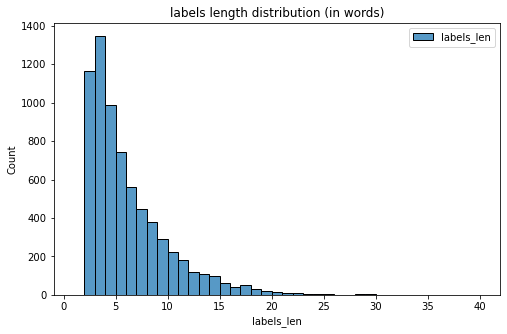

In [108]:
plot_lengths(data_w_len, "labels", binrange=(1, 40), binwidth=1)

question_len [ 4 27 ]


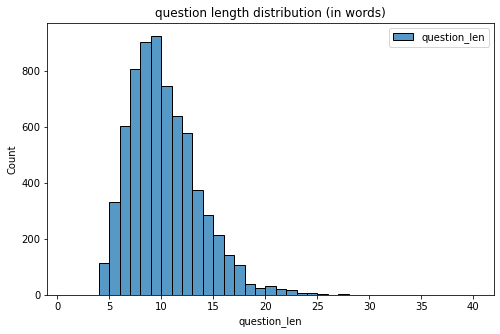

In [104]:
plot_lengths(data_w_len, "question", binrange=(1, 40), binwidth=1)

context_len [ 235 1234 ]


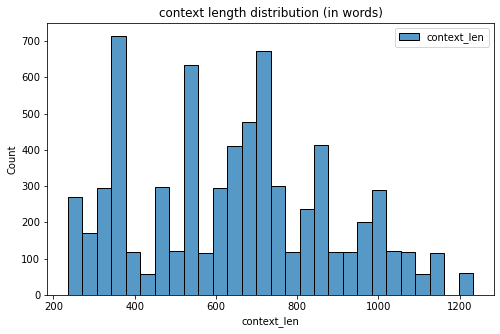

In [103]:
plot_lengths(data_w_len, "context")

In [80]:
data_w_len

Dataset({
    features: ['example_id', 'title', 'question', 'context', 'labels', 'multi_way_labels', 'answer_id', 'question_len', 'context_len', 'labels_len'],
    num_rows: 21114
})

In [109]:
N_WORDS = 10
data_to_file = data_w_len.filter(lambda example: example['labels_len'] >= N_WORDS)
data_to_file = data_to_file.remove_columns(['question_len', 'context_len', 'labels_len'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 120.24ba/s]


In [110]:
BASE_FILENAME = f"{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}_len_{N_WORDS}"

MATRIX_FILEPATH = f"{MATRIX_DIR}/{BASE_FILENAME}_preprocessed.csv.gz"
print("Writing matrix at filepath:", MATRIX_FILEPATH)

data_to_file.to_csv(
    MATRIX_FILEPATH[:-3],
    index=False,
    **csv_kwargs,
)

Writing matrix at filepath: ../outputs/results/narrativeqa/dev/matrix/narrativeqa_dev_len_10_preprocessed.csv.gz


Creating CSV from Arrow format:   0%|                                                                                                                                                        | 0/1 [00:00<?, ?ba/s]/home/kat/miniconda3/envs/gqa-env/lib/python3.9/site-packages/datasets/io/csv.py:95: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  csv_str = batch.to_pandas().to_csv(
Creating CSV from Arrow format: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03ba/s]


3579863